In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import pdb;


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
#sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
from torchdiffeq import odeint_adjoint as odeint
from torch.distributions import MultivariateNormal
use_cuda = torch.cuda.is_available()

### Euler ODE Solver

In [2]:
#ode solver

def ode_solve(z0, t0, t1, f):
    """
    Use Euler's method
    
    Solves the ode z' = f(t,z) with initial condition z(t_0) = z0
    returns z(t1).
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max))#.max().item())
    print(n_steps)
    h = (t1 - t0)/n_steps
    t = t0
    z = z0
    #pdb.set_trace()
    for i_step in range(n_steps):
        z = z + h * f(t,z)
        t = t + h
    return z

def ode_solve_tuple(z0, t0, t1, f):
    """
    Use Euler's method
    
    Solves the ode z' = f(t,z) with initial condition z(t_0) = z0
    returns z(t1).
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max))#.max().item())
    n_steps = np.max([n_steps,200])
    #print(n_steps)
    h = (t1 - t0)/n_steps
    t = t0
    z = z0
    #pdb.set_trace()
    for i_step in range(n_steps):
        adj = f(t,z)
        z = (z[0] + h* adj[0],z[1] + h* adj[1])
        #z = z + h * f(t,z)
        t = t + h
    return z

#### View approximation error

In [3]:
t0 = 0
t1 = 100

def ftest(z,t):
    return z
#print(ode_solve(10,0,100,ftest))

def analytic_sol(z0,t1):
    return z0* np.exp(t1)

#print(analytic_sol(10,100))

### Define CNF class

In [4]:
class ODEfunc(nn.Module):
    """
    Calculates time derivatives.

    torchdiffeq requires this to be a torch.nn.Module.
    """

    def __init__(self, hidden_dims=(64,64)):
        super(ODEfunc, self).__init__()
        # Define network layers.
        Z_DIM=2
        dim_list = [Z_DIM] + list(hidden_dims) + [Z_DIM]
        layers = []
        for i in range(len(dim_list)-1):
            layers.append(nn.Linear(dim_list[i]+1, dim_list[i+1]))
        self.layers = nn.ModuleList(layers)


    def get_z_dot(self, t, z):
        """z_dot is parameterized by a NN: z_dot = NN(t, z(t))"""
        z_dot = z
        for l, layer in enumerate(self.layers):
            # Concatenate t at each layer.
            #pdb.set_trace()
            tz_cat = torch.cat((t.expand(z.shape[0],1), z_dot), dim=1)
            z_dot = layer(tz_cat) #add time t into first spot
            if l < len(self.layers) - 1:
                z_dot = F.softplus(z_dot)
        return z_dot


    def forward(self, t, state):
        """
        Calculate the time derivative of z and divergence.

        Parameters
        ----------
        t : torch.Tensor
            time
        state : tuple
            Contains two torch.Tensors: z and delta_logpz

        Returns
        -------
        z_dot : torch.Tensor
            Time derivative of z.
        negative_divergence : torch.Tensor
            Time derivative of the log determinant of the Jacobian.
        """
        z = state[0]
        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            t.requires_grad_(True)

            # Calculate the time derivative of z.
            # This is f(z(t), t; \theta) in Eq. 4.
            z_dot = self.get_z_dot(t, z)

            # Calculate the time derivative of the log determinant of the
            # Jacobian.
            # This is -Tr(\partial z_dot / \partial z(t)) in Eq.s 2-4.
            #
            # Note that this is the brute force, O(D^2), method. This is fine
            # for D=2, but the authors suggest using a Monte-carlo estimate
            # of the trace (Hutchinson's trace estimator, eq. 7) for a linear
            # time estimate in larger dimensions.
            divergence = 0.0
            for i in range(z.shape[1]):
                divergence += torch.autograd.grad( z_dot[:, i].sum(), z, create_graph=True)[0][:, i]

        return z_dot, -divergence.view(batchsize, 1)

In [5]:
class FfjordModel(torch.nn.Module):
    """Continuous noramlizing flow model."""

    def __init__(self):
        super(FfjordModel, self).__init__()
        self.time_deriv_func = ODEfunc()

    def save_state(self, fn='state.tar'):
        """Save model state."""
        torch.save(self.state_dict(), fn)

    def load_state(self, fn='state.tar'):
        """Load model state."""
        self.load_state_dict(torch.load(fn))


    def forward(self, z, delta_logpz=None, integration_times=None, reverse=False):
        """
        Implementation of Eq. 4.
        We want to integrate both f and the trace term. During training, we
        integrate from t_1 (data distribution) to t_0 (base distibution).
        Parameters
        ----------
        z : torch.Tensor
            Samples.
        delta_logpz : torch.Tensor
            Log determininant of the Jacobian.
        integration_times : torch.Tensor
            Which times to evaluate at.
        reverse : bool, optional
            Whether to reverse the integration times.
        Returns
        -------
        z : torch.Tensor
            Updated samples.
        delta_logpz : torch.Tensor
            Updated log determinant term.
        """
        if delta_logpz is None:
            delta_logpz = torch.zeros(z.shape[0], 1).to(device)
        if integration_times is None:
            integration_times = torch.tensor([0.0, 1.0]).to(z)
        if reverse:
            integration_times = _flip(integration_times, 0)
        #print('integration_times',integration_times)
        # Integrate. This is the call to torchdiffeq.
        """state = odeint(
            self.time_deriv_func, # Calculates time derivatives.
            (z, delta_logpz), # Values to update.
            integration_times, # When to evaluate.
            method='dopri5', # Runge-Kutta
            atol=[1e-5, 1e-5], # Error tolerance
            rtol=[1e-5, 1e-5], # Error tolerance
        )"""
        #print('z',z.shape)
        #print('delta_logpz',delta_logpz.shape)
        state = ode_solve_tuple((z,delta_logpz),integration_times[0],integration_times[1],self.time_deriv_func)
        #print('state',state[0].shape,state[1].shape)
        #delta_logpz = ode_solve(delta_logpz,integration_times[0],integration_times[1],self.time_deriv_func)
        #pdb.set_trace()
        #if len(integration_times) == 2:
            #state = tuple(s[1] for s in state)
        z, delta_logpz = state
        return z, delta_logpz
    
def _flip(x, dim):
    indices = [slice(None)] * x.dim()
    indices[dim] = torch.arange(x.size(dim) - 1, -1, -1, dtype=torch.long, \
            device=x.device)
    return x[tuple(indices)]

### Test in practice

#### Build dataset

In [6]:
def make_image(n=10000):
    """Make an X shape."""
    points = np.zeros((n,2))
    points[:n//2,0] = np.linspace(-1,1,n//2)
    points[:n//2,1] = np.linspace(1,-1,n//2)
    points[n//2:,0] = np.linspace(1,-1,n//2)
    points[n//2:,1] = np.linspace(1,-1,n//2)
    np.random.seed(42)
    noise = np.clip(np.random.normal(scale=0.1, size=points.shape),-0.2,0.2)
    np.random.seed(None)
    points += noise
    img, _ = np.histogramdd(points, bins=40, range=[[-1.5,1.5],[-1.5,1.5]])
    return img


class ImageDataset():
    """Sample from a distribution defined by an image."""

    def __init__(self, img):
        h, w = img.shape
        xx = np.linspace(-MAX_VAL, MAX_VAL, w)
        yy = np.linspace(-MAX_VAL, MAX_VAL, h)
        xx, yy = np.meshgrid(xx, yy)
        xx = xx.reshape(-1, 1)
        yy = yy.reshape(-1, 1)
        self.means = np.concatenate([xx, yy], 1)
        self.probs = img.reshape(-1) / img.sum()
        self.noise_std = np.array([MAX_VAL/w, MAX_VAL/h])

    def sample(self, batch_size=512):
        inds = np.random.choice(int(self.probs.shape[0]), int(batch_size), p=self.probs)
        m = self.means[inds]
        samples = np.random.randn(*m.shape) * self.noise_std + m
        return torch.from_numpy(samples).type(torch.FloatTensor)

In [7]:
MAX_VAL=4.0
dset = ImageDataset(img=make_image())
dset.sample().shape

torch.Size([512, 2])

#### Test data set

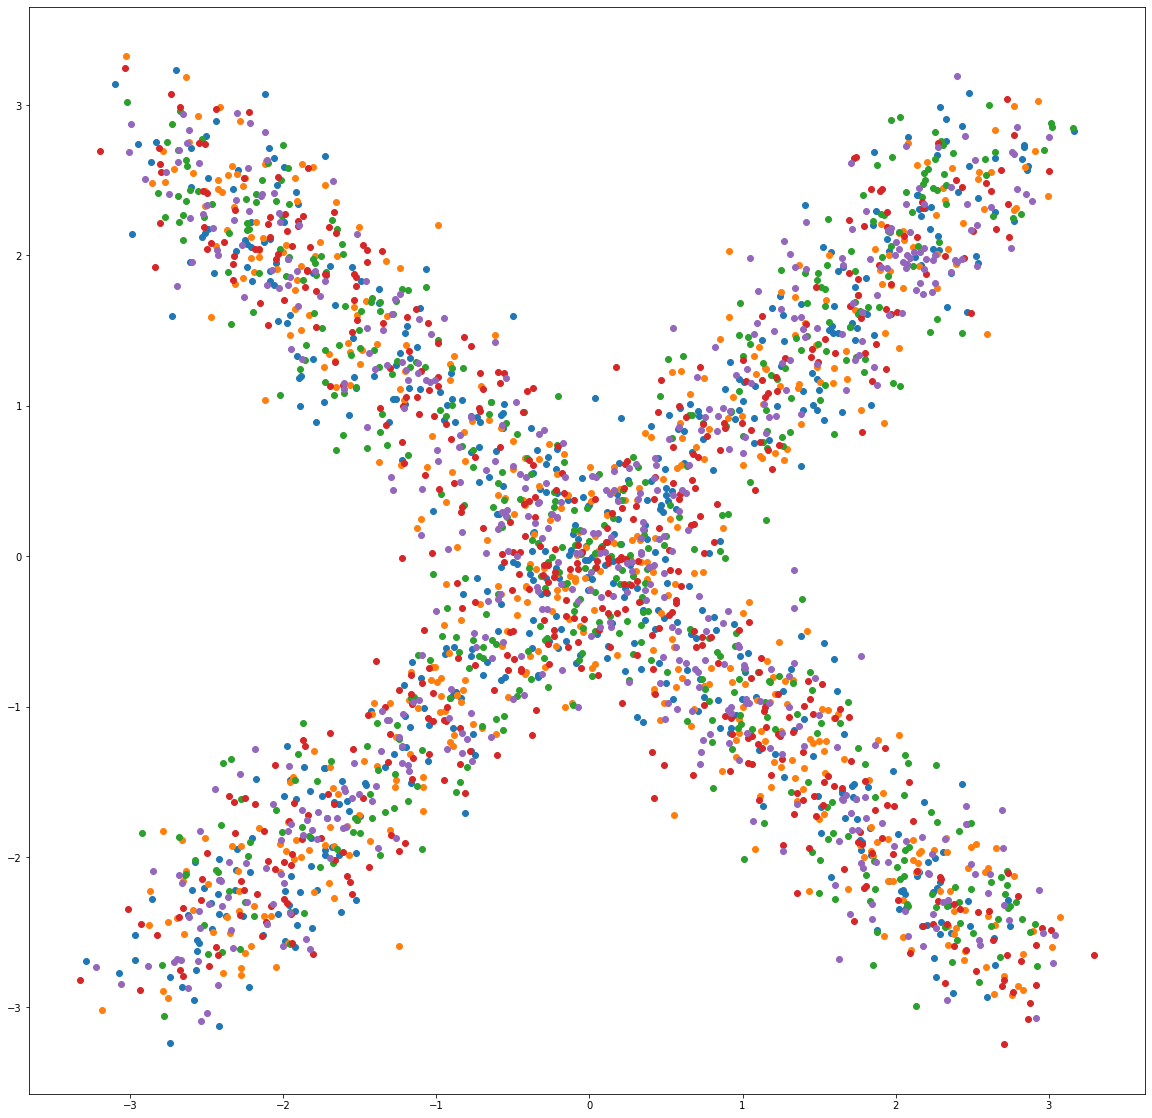

In [8]:
plt.figure(figsize=(20,20))
for i in range(5):
    dat = dset.sample(512)
    plt.scatter(dat[:,0],dat[:,1])

#### Define Model

In [9]:
model = FfjordModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

FfjordModel(
  (time_deriv_func): ODEfunc(
    (layers): ModuleList(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Linear(in_features=65, out_features=64, bias=True)
      (2): Linear(in_features=65, out_features=2, bias=True)
    )
  )
)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.train()

FfjordModel(
  (time_deriv_func): ODEfunc(
    (layers): ModuleList(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Linear(in_features=65, out_features=64, bias=True)
      (2): Linear(in_features=65, out_features=2, bias=True)
    )
  )
)

In [11]:
losses = []
for batch in range(3000):
    # Zero gradients.
    #pdb.set_trace()
    optimizer.zero_grad()
    #print('1')
    # Sample from the image distribution.
    z_t1 = dset.sample(512).to(device)
    # Transform to the image samples to base distribution samples.
    z_t0, delta_logpz = model(z_t1)
    #pdb.set_trace()
    #print('2')
    # Calculate a loss: Eq. 3
    # Log likelihood of the base distribution samples.
    prior = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))
    logpz_t0 = prior.log_prob(z_t0)
    #print('3')
    # Subtract the correction term (log determinant of the Jacobian). Note
    # that we integrated from t_1 to t_0 and integrated a negative trace
    # term, so the signs align with Eq. 3.
    logpz_t1 = logpz_t0 - delta_logpz
    #print('4')
    loss = -torch.mean(logpz_t1)
    if (batch % 10 == 0):
        print('batch',batch,'loss',loss)
    losses.append(loss)
    #print('5')
    #print('6')
    # Take an optimization step.
    loss.backward()
    #print('7')
    optimizer.step()
    #print('8')

# Save the parameters of the model.
#model.save_state()

batch 0 loss tensor(4.2855, grad_fn=<NegBackward>)
batch 10 loss tensor(3.9790, grad_fn=<NegBackward>)
batch 20 loss tensor(3.8826, grad_fn=<NegBackward>)
batch 30 loss tensor(3.8171, grad_fn=<NegBackward>)
batch 40 loss tensor(3.7438, grad_fn=<NegBackward>)
batch 50 loss tensor(3.7921, grad_fn=<NegBackward>)
batch 60 loss tensor(3.6650, grad_fn=<NegBackward>)
batch 70 loss tensor(3.7259, grad_fn=<NegBackward>)
batch 80 loss tensor(3.7359, grad_fn=<NegBackward>)
batch 90 loss tensor(3.8596, grad_fn=<NegBackward>)
batch 100 loss tensor(3.7320, grad_fn=<NegBackward>)
batch 110 loss tensor(3.8161, grad_fn=<NegBackward>)
batch 120 loss tensor(3.7738, grad_fn=<NegBackward>)
batch 130 loss tensor(3.8343, grad_fn=<NegBackward>)
batch 140 loss tensor(3.8159, grad_fn=<NegBackward>)
batch 150 loss tensor(3.8301, grad_fn=<NegBackward>)
batch 160 loss tensor(3.8509, grad_fn=<NegBackward>)
batch 170 loss tensor(3.7798, grad_fn=<NegBackward>)
batch 180 loss tensor(3.7305, grad_fn=<NegBackward>)
batc

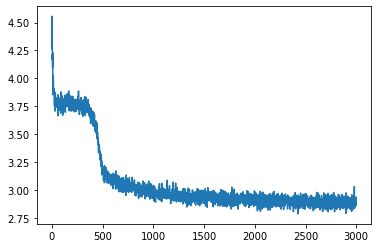

In [12]:
plt.plot(losses)

### plot results

In [13]:
#try plotting 
n=10000
samples = prior.sample_n(n)
z_samples = torch.zeros(n, 2).to(device).detach()
new_x = model(samples,integration_times=torch.linspace(0,1.0,2),reverse=True)[0].cpu().detach()
X = dset.sample(n)

/Users/edwardgoul/opt/anaconda3/envs/torchdyn/lib/python3.8/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


In [14]:
print(model)

FfjordModel(
  (time_deriv_func): ODEfunc(
    (layers): ModuleList(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Linear(in_features=65, out_features=64, bias=True)
      (2): Linear(in_features=65, out_features=2, bias=True)
    )
  )
)


(-2.0, 2.0)

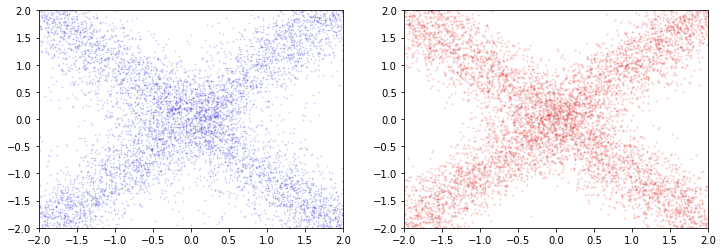

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(new_x[:,0], new_x[:,1], s=2.3, alpha=0.2, linewidths=0.1, c='blue', edgecolors='black')
plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.subplot(122)
plt.scatter(X[:,0], X[:,1], s=3.3, alpha=0.2, c='red',  linewidths=0.1, edgecolors='black')
plt.xlim(-2, 2)
plt.ylim(-2, 2)